### Overview
The notebook aims to predict flood warnings (binary daily_indicator with 1 indicating a flood warning) using Environemnt Agency Hydrology API data only: water level readings from two river gauge stations, river flow, and rainfall (aggregated hourly). The data utilised was led by the choice of Flood Warning Area. The approach involves merging these datasets on timestamps, engineering features (like lagged levels and accumulated rainfall), and training classification models (Logistic Regression and Random Forest) to identify conditions that trigger flood warnings. Preprocessing and some feature exploration for ML occurred in supporting [PREPROCESSING] files. This is a time-series prediction problem with a highly imbalanced target (very few flood events compared to non-events).

In [0]:
#Import modules and libraries
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt    
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import TimeSeriesSplit
from collections import Counter
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import DecisionTreeClassifier, export_text


In [0]:
#Load Level data.
level = pd.read_csv(os.path.join("Data", "Level_Cleaned_Hourly.csv"))
level

,station,dateTime,value
0,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 00:00:00,2.198
1,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 01:00:00,2.291
2,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 02:00:00,2.293
3,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 03:00:00,2.266
4,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 04:00:00,2.229
...,...,...,...
86539,ce5176cf-1523-4dbe-855f-17a0efffbe02,2024-11-24 19:00:00,2.520
86540,ce5176cf-1523-4dbe-855f-17a0efffbe02,2024-11-24 20:00:00,2.513
86541,ce5176cf-1523-4dbe-855f-17a0efffbe02,2024-11-24 21:00:00,2.503
86542,ce5176cf-1523-4dbe-855f-17a0efffbe02,2024-11-24 22:00:00,2.506


In [0]:
#Checking the number of level stations. 
level.nunique()

station         2
dateTime    43272
value        6721
dtype: int64

In [0]:
#Rename the 'value' column to 'level'.
level.rename(columns={"value": "level"}, inplace=True)

In [0]:
level

,station,dateTime,level
0,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 00:00:00,2.198
1,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 01:00:00,2.291
2,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 02:00:00,2.293
3,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 03:00:00,2.266
4,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 04:00:00,2.229
...,...,...,...
86539,ce5176cf-1523-4dbe-855f-17a0efffbe02,2024-11-24 19:00:00,2.520
86540,ce5176cf-1523-4dbe-855f-17a0efffbe02,2024-11-24 20:00:00,2.513
86541,ce5176cf-1523-4dbe-855f-17a0efffbe02,2024-11-24 21:00:00,2.503
86542,ce5176cf-1523-4dbe-855f-17a0efffbe02,2024-11-24 22:00:00,2.506


In [0]:
#Exploring missing values.
level.isna().sum()

station     0
dateTime    0
level       0
dtype: int64

In [0]:
#Pivot the dataframe to spearate the different station readings.
level = level.pivot(index="dateTime", columns="station", values="level")

#Rename columns to append ' level' to each station name.
level.columns = [f"{col} level" for col in level.columns]

#Reset index to make 'dateTime' a column again.
level = level.reset_index()

In [0]:
level

,dateTime,7998bf73-641d-4084-b00c-ca6989f2ba2b level,ce5176cf-1523-4dbe-855f-17a0efffbe02 level
0,2019-12-19 00:00:00,2.198,4.588
1,2019-12-19 01:00:00,2.291,3.412
2,2019-12-19 02:00:00,2.293,2.718
3,2019-12-19 03:00:00,2.266,2.369
4,2019-12-19 04:00:00,2.229,2.309
...,...,...,...
43267,2024-11-24 19:00:00,2.334,2.520
43268,2024-11-24 20:00:00,2.379,2.513
43269,2024-11-24 21:00:00,2.404,2.503
43270,2024-11-24 22:00:00,2.410,2.506


In [0]:
#Load the warning data.
new_warnings = pd.read_csv(os.path.join("Data", "Warnings_Filled.csv")) 
new_warnings

,Approved,daily_indicator
0,2019-12-19 01:00:00,1
1,2019-12-19 02:00:00,1
2,2019-12-19 03:00:00,1
3,2019-12-19 04:00:00,1
4,2019-12-19 05:00:00,1
...,...,...
43278,2024-11-25 07:00:00,1
43279,2024-11-25 08:00:00,1
43280,2024-11-25 09:00:00,1
43281,2024-11-25 10:00:00,1


In [0]:
#Ensure the dateTime column is in the datetime format. 
new_warnings['Approved'] = pd.to_datetime(new_warnings['Approved'])
level['dateTime'] = pd.to_datetime(level['dateTime'])


In [0]:
#Merge the datasets.
level_warnings = new_warnings.merge(level, left_on='Approved', right_on='dateTime', how='inner')


In [0]:
#Ensure the dateTime column is in the datetime format. 
level_warnings['dateTime'] = pd.to_datetime(level_warnings['dateTime'])


In [0]:
#Drop the duplicated column.
level_warnings.drop(columns=["Approved"])

,daily_indicator,dateTime,7998bf73-641d-4084-b00c-ca6989f2ba2b level,ce5176cf-1523-4dbe-855f-17a0efffbe02 level
0,1,2019-12-19 01:00:00,2.291,3.412
1,1,2019-12-19 02:00:00,2.293,2.718
2,1,2019-12-19 03:00:00,2.266,2.369
3,1,2019-12-19 04:00:00,2.229,2.309
4,1,2019-12-19 05:00:00,2.204,2.294
...,...,...,...,...
43266,1,2024-11-24 19:00:00,2.334,2.520
43267,1,2024-11-24 20:00:00,2.379,2.513
43268,1,2024-11-24 21:00:00,2.404,2.503
43269,1,2024-11-24 22:00:00,2.410,2.506


### Exploratory Data Analysis 

Exploring the relationship between river levels for the two stations and flood warnings.


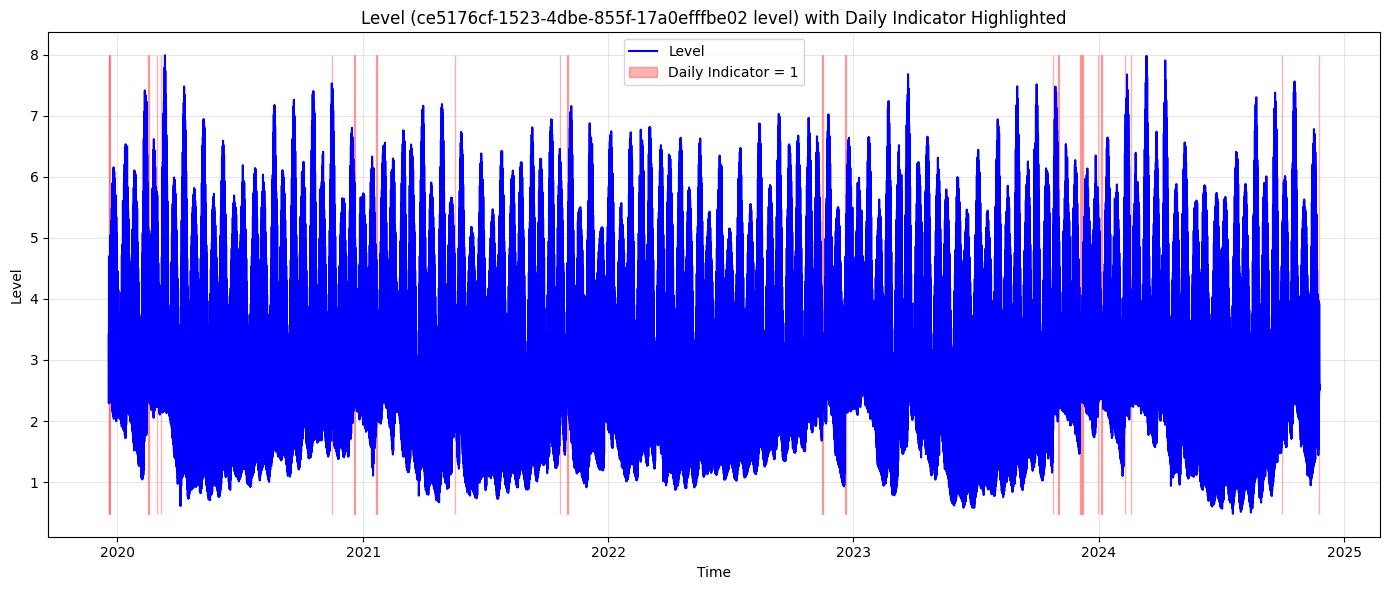

In [0]:
#Visualise the data for water level and whether there is a flood warning in place. 
plt.figure(figsize=(14, 6))

#Plot the main level values
plt.plot(level_warnings['dateTime'], level_warnings['ce5176cf-1523-4dbe-855f-17a0efffbe02 level'], 
         label='Level', linewidth=1.5, color='blue')

#Highlight areas where daily_indicator == 1.
plt.fill_between(
    level_warnings['dateTime'],
    level_warnings['ce5176cf-1523-4dbe-855f-17a0efffbe02 level'].min(),
    level_warnings['ce5176cf-1523-4dbe-855f-17a0efffbe02 level'].max(),
    where=level_warnings['daily_indicator'] == 1,
    color='red',
    alpha=0.3,
    label='Daily Indicator = 1'
)
plt.xlabel('Time')
plt.ylabel('Level')
plt.title('Level (ce5176cf-1523-4dbe-855f-17a0efffbe02 level) with Daily Indicator Highlighted')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [0]:
#Create some desriptive statistics for the water level when there is a flood warning in place. 

#Filter the data.
filtered_df = level_warnings[level_warnings['daily_indicator'] == 1]

#Generate descriptive statistics for the selected station.
print(filtered_df['ce5176cf-1523-4dbe-855f-17a0efffbe02 level'].agg(['mean', 'median', 'min', 'max', 'std', 'count']))

mean        3.030295
median      2.475500
min         1.689000
max         7.528000
std         1.056423
count     454.000000
Name: ce5176cf-1523-4dbe-855f-17a0efffbe02 level, dtype: float64


In [0]:
#Create some desriptive statistics for the water level when there is not a flood warning in place. 

#Filter the data
filtered_df = level_warnings[level_warnings['daily_indicator'] == 0]

#Generate descriptive statistics for the selected station.
print(filtered_df['ce5176cf-1523-4dbe-855f-17a0efffbe02 level'].agg(['mean', 'median', 'min', 'max', 'std', 'count']))

mean          2.668960
median        2.172000
min           0.482000
max           7.988000
std           1.542546
count     42817.000000
Name: ce5176cf-1523-4dbe-855f-17a0efffbe02 level, dtype: float64


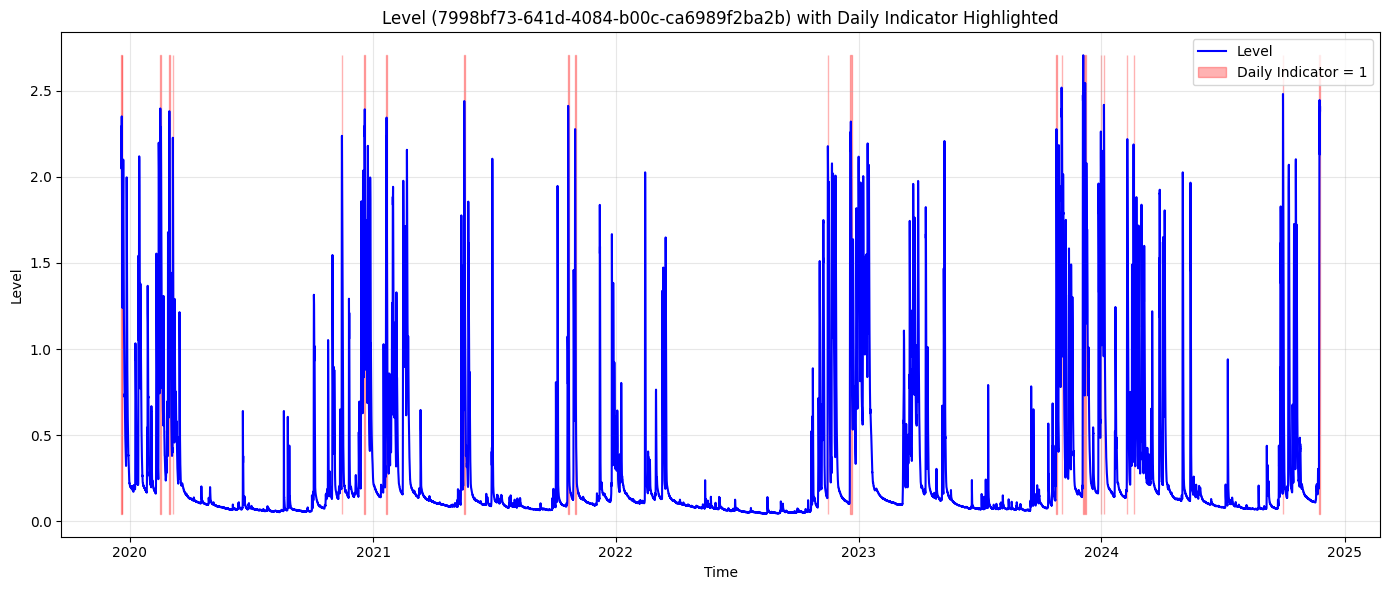

In [0]:
#Visualise the data for water level and whether there is a flood warning in place. 
plt.figure(figsize=(14, 6))

#Plot the main level values.
plt.plot(level_warnings['dateTime'], level_warnings['7998bf73-641d-4084-b00c-ca6989f2ba2b level'], 
         label='Level', linewidth=1.5, color='blue')

# ighlight areas where daily_indicator == 1.
plt.fill_between(
    level_warnings['dateTime'],
    level_warnings['7998bf73-641d-4084-b00c-ca6989f2ba2b level'].min(),
    level_warnings['7998bf73-641d-4084-b00c-ca6989f2ba2b level'].max(),
    where=level_warnings['daily_indicator'] == 1,
    color='red',
    alpha=0.3,
    label='Daily Indicator = 1'
)
plt.xlabel('Time')
plt.ylabel('Level')
plt.title('Level (7998bf73-641d-4084-b00c-ca6989f2ba2b) with Daily Indicator Highlighted')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [0]:
#Create some desriptive statistics for the water level when there is a flood warning in place. 
filtered_df = level_warnings[level_warnings['daily_indicator'] == 1]

# Generate descriptive statistics for the selected level
print(filtered_df['7998bf73-641d-4084-b00c-ca6989f2ba2b level'].agg(['mean', 'median', 'min', 'max', 'std', 'count']))

mean        2.131533
median      2.179500
min         0.953000
max         2.706000
std         0.282926
count     454.000000
Name: 7998bf73-641d-4084-b00c-ca6989f2ba2b level, dtype: float64


In [0]:
#Create some desriptive statistics for the water level when there is not a flood warning in place. 

#Filter the data.
filtered_df = level_warnings[level_warnings['daily_indicator'] == 0]

# Generate descriptive statistics for the selected station.
print(filtered_df['7998bf73-641d-4084-b00c-ca6989f2ba2b level'].agg(['mean', 'median', 'min', 'max', 'std', 'count']))

mean          0.276835
median        0.122000
min           0.043000
max           2.440000
std           0.397946
count     42817.000000
Name: 7998bf73-641d-4084-b00c-ca6989f2ba2b level, dtype: float64


nOTE: Station 7998 (likely upstream) vs station ce5176 (downstream or effected by something like flood gates) - futher investigation needed. Correlation, just from looking at the visualisations and descriptive statistics, will likely be markedly lower for ce5176 and flood warning events. I will check the feature importance and consider removing ce5176. Edit: As ce55176 did not contribute adequately to the model, it was later removed. 

In [0]:
#Sort the values by dateTime.
level_warnings = level_warnings.sort_values('dateTime', ascending=True).reset_index(drop=True)


In [0]:
level_warnings

,Approved,daily_indicator,dateTime,7998bf73-641d-4084-b00c-ca6989f2ba2b level,ce5176cf-1523-4dbe-855f-17a0efffbe02 level
0,2019-12-19 01:00:00,1,2019-12-19 01:00:00,2.291,3.412
1,2019-12-19 02:00:00,1,2019-12-19 02:00:00,2.293,2.718
2,2019-12-19 03:00:00,1,2019-12-19 03:00:00,2.266,2.369
3,2019-12-19 04:00:00,1,2019-12-19 04:00:00,2.229,2.309
4,2019-12-19 05:00:00,1,2019-12-19 05:00:00,2.204,2.294
...,...,...,...,...,...
43266,2024-11-24 19:00:00,1,2024-11-24 19:00:00,2.334,2.520
43267,2024-11-24 20:00:00,1,2024-11-24 20:00:00,2.379,2.513
43268,2024-11-24 21:00:00,1,2024-11-24 21:00:00,2.404,2.503
43269,2024-11-24 22:00:00,1,2024-11-24 22:00:00,2.410,2.506


In [0]:
#Checking for nulls.
level_warnings.isna().sum()

Approved                                      0
daily_indicator                               0
dateTime                                      0
7998bf73-641d-4084-b00c-ca6989f2ba2b level    0
ce5176cf-1523-4dbe-855f-17a0efffbe02 level    0
dtype: int64

## Modeling Approach

I will train two classification models to predict `daily_indicator` (flood warning):
1. **Logistic Regression** – as a simple baseline. I anticipate it may struggle due to non-linear relationships and class imbalance, but it provides a interpretable benchmark.
2. **Random Forest Classifier** – an ensemble tree model that can capture nonlinear interactions. I will use this as our primary model and later tune its hyperparameters.

**Train/Test Split:** I split the data chronologically, training on data up to 2023 and testing on 2024, to respect time order.

I'll evaluate models primarily by **recall** (sensitivity to flood events) and **precision** (false alarm rate), since catching flood events is critical, but too many false alarms could be problematic. F1-score provides a balance of both.


In [0]:
#Create a 'features' variable which holds the input features. 
excluded_cols = ["Approved", "dateTime", "daily_indicator"]
features = [col for col in level_warnings.columns if col not in excluded_cols]

features

['7998bf73-641d-4084-b00c-ca6989f2ba2b level',
 'ce5176cf-1523-4dbe-855f-17a0efffbe02 level']

In [0]:
#Define the target variable. 
target = "daily_indicator"

#Chronological train/test split:
train = level_warnings[level_warnings["dateTime"] < "2024-01-01"]
test = level_warnings[level_warnings["dateTime"] >= "2024-01-01"]

#Separate into X (independent variables) and y (dependent variables).
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

#Print dataset sizes for inspection.
print("Train size:", len(X_train), "rows")
print("Test size:", len(X_test), "rows")

#Count occurrences of daily_indicator == 1 (flood events).
train_flood_count = y_train.value_counts().get(1, 0)
test_flood_count = y_test.value_counts().get(1, 0)

#Print flood counts for inspection.
print(f"Flood events in train set (daily_indicator=1): {train_flood_count}")
print(f"Flood events in test set (daily_indicator=1): {test_flood_count}")


Train size: 35375 rows
Test size: 7896 rows
Flood events in train set (daily_indicator=1): 387
Flood events in test set (daily_indicator=1): 67


In [0]:
#Start with Logstic Regression model as a baseline and with no feature engineering. 

#Define and train Logistic Regression model.
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)

#Predictions.
y_pred_lr = log_reg.predict(X_test)

#Evaluate accuracy.
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

#Display the confusion matrix.
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

#The initial logistic regression model, trained without any additional feature engineering, achieved an overall **accuracy of 99.6%**. However, due to the severe class imbalance, accuracy alone is misleading and it missed 25 flood warnings as false negatives. 

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run kindly-duck-133 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/5ecb342b070b4b66bf62834a787ea3c2
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
Logistic Regression Accuracy: 0.9963272543059777
Confusion Matrix:
[[7825    4]
 [  25   42]]


In [0]:
#Next, a more complex model as a baselines without feature engineering. 

#Train the Random Forest model.
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

#Make predictions
y_pred = rf_model.predict(X_test)

#Evaluate model performance
print(classification_report(y_test, y_pred))

#The baseline Random Forest model significantly improved detection of flood events compared to logistic regression. It gave a reasonable result without hyperparameter tuning and feature engineering.

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run tasteful-gull-609 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/088f5fe6fe1240ee87a8530df4555302
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7829
           1       0.31      0.91      0.47        67

    accuracy                           0.98      7896
   macro avg       0.66      0.95      0.73      7896
weighted avg       0.99      0.98      0.99      7896



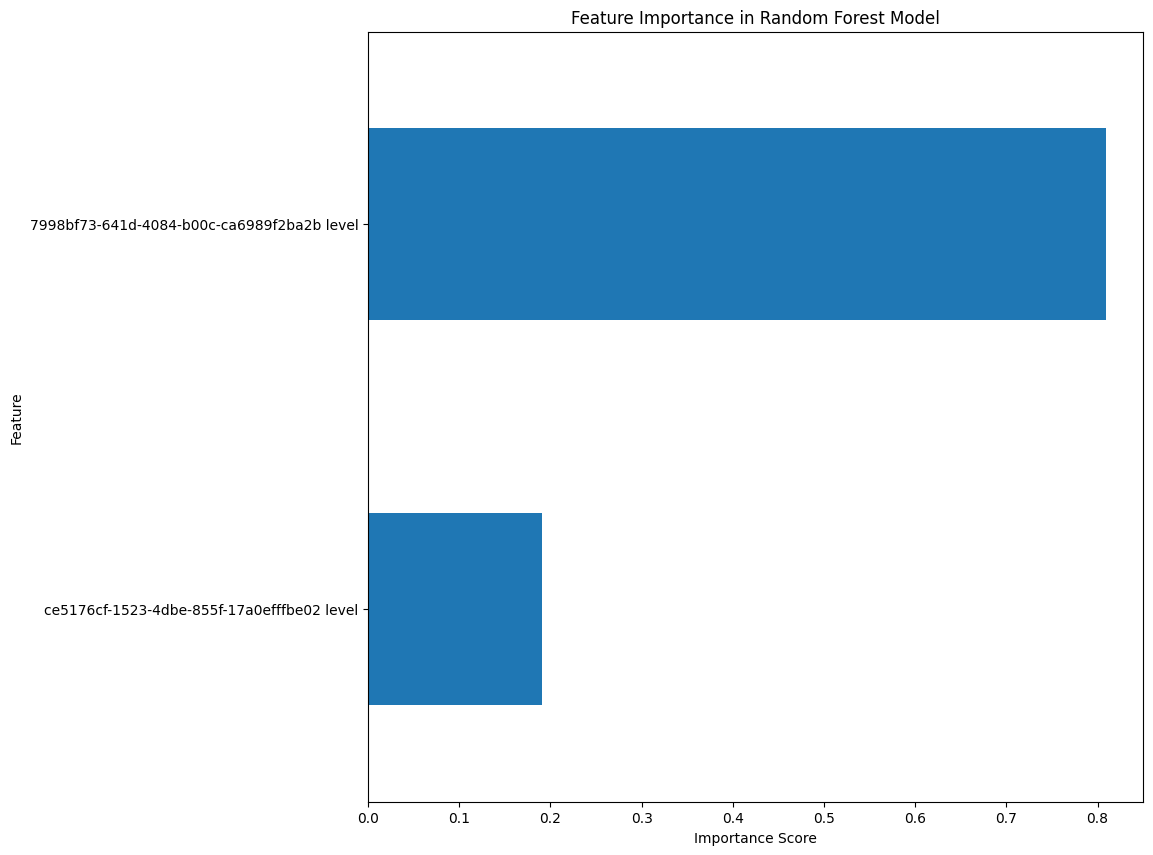

In [0]:
#Visualising the feature importance.
feature_importances = pd.Series(rf_model.feature_importances_, index=features)
feature_importances.sort_values().plot(kind="barh", figsize=(10, 10))
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.show()

#As ce5176 does not contribute much to the model, it will be removed and feature engineering will focus on 7998b and other datasets such as rainfall and flow. The decision to remove this was not based solely on this feature importance visual, it was by iterating futher models both with and without it and having more success when it was not included. 

### Baseline Handling Class Imbalance and Hyperparameter Tuning
Given the class imbalance (flood events are rare), I will test the use class weighting and oversampling (SMOTE). Additionally, a GridSearchCV will be performed to tune hyperparameters of the Random Forest (e.g., number of trees, max depth, min samples split) using cross-validation. I will do this sequentially to gauge the impact on the results. I used F1 score in grid search to balance the need for detecting floods (recall) with avoiding excessive false alarms (precision). Note: Initially, I used StratifiedKFold for the cross-validation but as this could cause potential data leakage in time series I then moved to TimeSeriesSplit for hyperparameter tuning to avoid peeking into future data, although this meant that some folds ended up with 0 and so StratifiedKFold was used with no shuffling.

In [0]:
#Find the best parameters using GridSearchCV with StratifiedKFold to preserve the imbalance ratio in each fold.

# Define the parameter grid tailored for imbalanced data
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    # Using class_weight to counter the imbalance:
    'class_weight': ["balanced", "balanced_subsample"]  
}

# Initialise the Random Forest classifier without fixed parameters so grid search can explore.
rf = RandomForestClassifier(random_state=42)

# Set up a StratifiedKFold cross-validation strategy (no shuffling to retain approximate time order)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=False)

#Set up GridSearchCV. Here, the scoring metric is set to 'f1'.
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=cv_strategy,
                           scoring='f1',  
                           n_jobs=-1,
                           verbose=1)

# Fit the grid search on the training data.
grid_search.fit(X_train, y_train)

# Output the best parameters and best score.
print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

# Retrieve the best model from grid search.
best_model = grid_search.best_estimator_

# Make predictions on the test set.
y_pred = best_model.predict(X_test)

# Evaluate the model's performance.
print(classification_report(y_test, y_pred))

#After performing hyperparameter tuning using `GridSearchCV` with `StratifiedKFold` cross-validation, the results show a **significant improvement in flood event detection** compared to baseline models, achieving a strong balance between **high recall (84%)** and improved precision. The model correctly identified the majority of flood warnings, while keeping false positives relatively low. The high accuracy and weighted averages reflect strong overall performance, while the macro averages indicate improved fairness between the minority and majority classes. Next is to try using SMOTE and guage the effects.

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run auspicious-skink-820 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/5f7799a98d4542a1912eca22402425c9
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run victorious-doe-462 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/17aed969383a4d4798a5a122df98015f
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run gentle-lamb-928 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/e18932f28eb647f585fcf2a67e87a5ae
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run worried-bug-101 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/d573fb7e351a452ba930bccf9df5dccf
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.

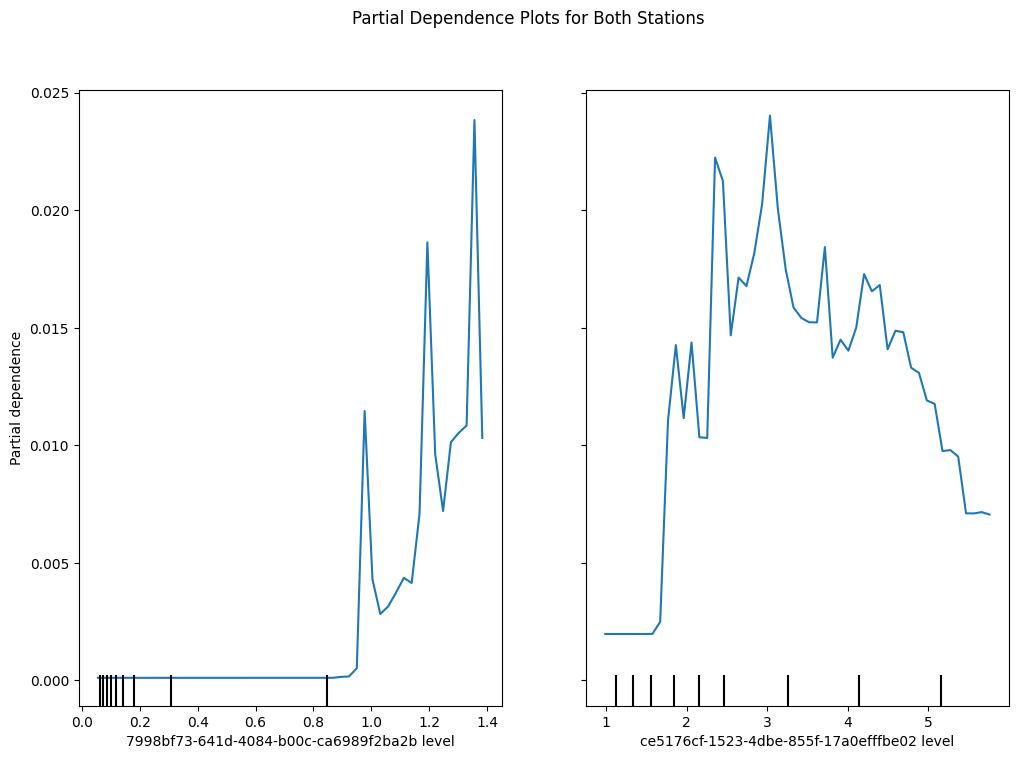

In [0]:
# Create partial dependence plots for all features used.
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(best_model, X_train, features=features, grid_resolution=50, ax=ax)
plt.suptitle("Partial Dependence Plots for Both Stations")
plt.show()

#The first station's levels has a strong, nonlinear relationship with flood risk - flood warnings become significantly more likely when the level exceeds ~0.8–1.0m. In contrast, the second station's levels shows a negative correlation, suggesting it may be less useful for prediction, possibly due to lag effects. These insights indicate that the upstream station's level is a key predictor, while the downstream station's level may not contribute meaningfully to early warnings. It will be removed from the model in further iterations. 

In [0]:
#Repeating the previous code but using SMOTE to balance the classes.

#Create a pipeline that first applies SMOTE to balance the classes, then fits a RandomForestClassifier.
pipeline = imbpipeline([
    ('smote', SMOTE(random_state=42)),  
    ('rf', RandomForestClassifier(random_state=42))
])

#Define the parameter grid for hyperparameter tuning. 
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__class_weight': ["balanced", "balanced_subsample"]
}

#Set up a StratifiedKFold cross-validation strategy (no shuffling to retain approximate time order)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=False)

#Configure GridSearchCV with the time series split and 'F1' as the scoring metric.
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv_strategy,
                           scoring='f1',
                           n_jobs=-1,
                           verbose=1)

#Fit the grid search on the training data (which was previously split by time).
grid_search.fit(X_train, y_train)

#Output the best parameters and best recall score from the grid search.
print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

#Retrieve the best pipeline (which includes both the sampling and the classifier).
best_model = grid_search.best_estimator_

#Make predictions on the test set.
y_pred = best_model.predict(X_test)

#Evaluate the model's performance using a classification report.
print(classification_report(y_test, y_pred))

#I experimented with **SMOTE oversampling** to generate additional synthetic flood events in training folds. However, this did not improve performance in our case.

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rogue-shad-256 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/51f59d1faf064933b0d143194d13aa02
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run classy-shrew-0 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/94c673fc8b804b6c8e91760c527199ed
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run crawling-mole-283 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/3bf689bef01e4219abf08173eb47616b
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run victorious-cat-155 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/9c655e6f722a4ee5aa158616fc87dad7
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/m

# Overview
## Final Features (utilised in the best model)
**Feature Engineering:** To capture the precursors to flood warnings, I added time-based features:
- *Level lag 1h & 2h:* The river level an hour and two hours before. A high level in the recent past could be a warning sign of a future flood warning.
- *Level rolling avg 3h & 6h:* Short-term averages of level, smoothing out spikes and representing sustained level changes.
- *Level EWMA (3h, 6h, 9h, 12h, 24h):* Exponentially weighted means of level over various periods. These emphasise recent readings (for short spans) or capture longer trends (12–24h spans). A 24h EWMA, for instance, reflects the general level of the river over the past day.
- *Rainfall cumulative 12h, 3d, 2w:* Total rainfall in the 12 hours, 3 days, and 14 days prior. This accounts for immediate heavy rain as well as long-term wet conditions (soil saturation). I chose 3 days and 2 weeks to represent short-term vs. longer-term accumulation.
- *Flow lag 1h & 2h and Flow rolling avg/EWMA:* Similar to level, these features track the river flow’s recent history. Flow is related to level but provides a direct measure of water volume.

Below, is the process leading to the final features of the best Random Forest model. Some of the reasoning which underpins the feature decisions can be found in the [PREPROCESSING] files. 


## 1) Feature Engineering Using ONLY Level Data

In [0]:
#Create lagged features for the level column using 1, 2, and 6 hour lags
level_warnings['lag_1h'] = level_warnings['7998bf73-641d-4084-b00c-ca6989f2ba2b level'].shift(1)
level_warnings['lag_2h'] = level_warnings['7998bf73-641d-4084-b00c-ca6989f2ba2b level'].shift(2)


# Define rolling window sizes in hours (up to 48 hours)
rolling_windows_hours = [3, 6]

# Create rolling average features for each window size
for window in rolling_windows_hours:
    col_name = f'rolling_avg_{window}h'
    level_warnings[col_name] = level_warnings['7998bf73-641d-4084-b00c-ca6989f2ba2b level'].rolling(window=window).mean()

# Apply Exponential Weighted Moving Average (EWMA) with various spans (in hours)
ewma_spans = [3, 6, 24, 12, 9]
for span in ewma_spans:
    col_name = f'ewma_{span}h'
    level_warnings[col_name] = level_warnings['7998bf73-641d-4084-b00c-ca6989f2ba2b level'].ewm(span=span, adjust=False).mean()

level_warnings

,Approved,daily_indicator,dateTime,7998bf73-641d-4084-b00c-ca6989f2ba2b level,ce5176cf-1523-4dbe-855f-17a0efffbe02 level,lag_1h,lag_2h,rolling_avg_3h,rolling_avg_6h,ewma_3h,ewma_6h,ewma_24h,ewma_12h,ewma_9h
0,2019-12-19 01:00:00,1,2019-12-19 01:00:00,2.291,3.412,NaN,NaN,NaN,NaN,2.291000,2.291000,2.291000,2.291000,2.291000
1,2019-12-19 02:00:00,1,2019-12-19 02:00:00,2.293,2.718,2.291,NaN,NaN,NaN,2.292000,2.291571,2.291160,2.291308,2.291400
2,2019-12-19 03:00:00,1,2019-12-19 03:00:00,2.266,2.369,2.293,2.291,2.283333,NaN,2.279000,2.284265,2.289147,2.287414,2.286320
3,2019-12-19 04:00:00,1,2019-12-19 04:00:00,2.229,2.309,2.266,2.293,2.262667,NaN,2.254000,2.268475,2.284335,2.278427,2.274856
4,2019-12-19 05:00:00,1,2019-12-19 05:00:00,2.204,2.294,2.229,2.266,2.233000,NaN,2.229000,2.250054,2.277909,2.266977,2.260685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43266,2024-11-24 19:00:00,1,2024-11-24 19:00:00,2.334,2.520,2.263,2.203,2.266667,2.205667,2.277196,2.239313,2.067280,2.213062,2.226472
43267,2024-11-24 20:00:00,1,2024-11-24 20:00:00,2.379,2.513,2.334,2.263,2.325333,2.247000,2.328098,2.279223,2.092218,2.238591,2.256978
43268,2024-11-24 21:00:00,1,2024-11-24 21:00:00,2.404,2.503,2.379,2.334,2.372333,2.291167,2.366049,2.314874,2.117160,2.264038,2.286382
43269,2024-11-24 22:00:00,1,2024-11-24 22:00:00,2.410,2.506,2.404,2.379,2.397667,2.332167,2.388025,2.342053,2.140587,2.286494,2.311106


In [0]:
#Drop nulls created by feature engineering. 
level_warnings.dropna(inplace=True)

In [0]:
#Redefine 'features'.
excluded_cols = ["Approved", "dateTime", "daily_indicator", 'ce5176cf-1523-4dbe-855f-17a0efffbe02 level']
features = [col for col in level_warnings.columns if col not in excluded_cols]
features

['7998bf73-641d-4084-b00c-ca6989f2ba2b level',
 'lag_1h',
 'lag_2h',
 'rolling_avg_3h',
 'rolling_avg_6h',
 'ewma_3h',
 'ewma_6h',
 'ewma_24h',
 'ewma_12h',
 'ewma_9h']

In [0]:
#Chronological train/test split:
train = level_warnings[level_warnings["dateTime"] < "2024-01-01"]
test = level_warnings[level_warnings["dateTime"] >= "2024-01-01"]

#Separate into X (features) and y (target)
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

#Print dataset sizes.
print("Train size:", len(X_train), "rows")
print("Test size:", len(X_test), "rows")

#Count occurrences of daily_indicator == 1 (flood events)
train_flood_count = y_train.value_counts().get(1, 0)
test_flood_count = y_test.value_counts().get(1, 0)

#Print flood counts.
print(f"Flood events in train set (daily_indicator=1): {train_flood_count}")
print(f"Flood events in test set (daily_indicator=1): {test_flood_count}")

Train size: 35370 rows
Test size: 7896 rows
Flood events in train set (daily_indicator=1): 382
Flood events in test set (daily_indicator=1): 67


In [0]:
#Define the parameter grid tailored for imbalanced data.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    # Using class_weight to counter the imbalance:
    'class_weight': ["balanced", "balanced_subsample"]  
}

#Initialise the Random Forest classifier without fixed parameters so grid search can explore.
rf = RandomForestClassifier(random_state=42)

#Using StratifiedKFold to preserve the imbalance ratio in each fold.
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Set up GridSearchCV with the StratifiedKFold split and 'F1' as the scoring metric.
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=cv_strategy,
                           scoring='f1',  
                           n_jobs=-1,
                           verbose=1)

#Fit the grid search on the training data
grid_search.fit(X_train, y_train)

#Output the best parameters and best score.
print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

#Retrieve the best model from grid search.
best_model = grid_search.best_estimator_

#Make predictions on the test set.
y_pred = best_model.predict(X_test)

#Evaluate the model's performance.
print(classification_report(y_test, y_pred))

#While recall is still not fit-for-purpose, this version represents a major step forward, achieving a strong balance between detecting flood events (recall) and avoiding false positives (precision).

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run powerful-dolphin-322 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/3b9cdd597214455fb19fde89a4a0868a
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run mysterious-cub-612 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/6154a6e014db42a49f29b8f33b22c300
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run fortunate-mole-818 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/5a6ccdc097694fecacf3aca354f9a933
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run gifted-goat-583 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/2423163aaae647419aef34701da0cbdf
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabric

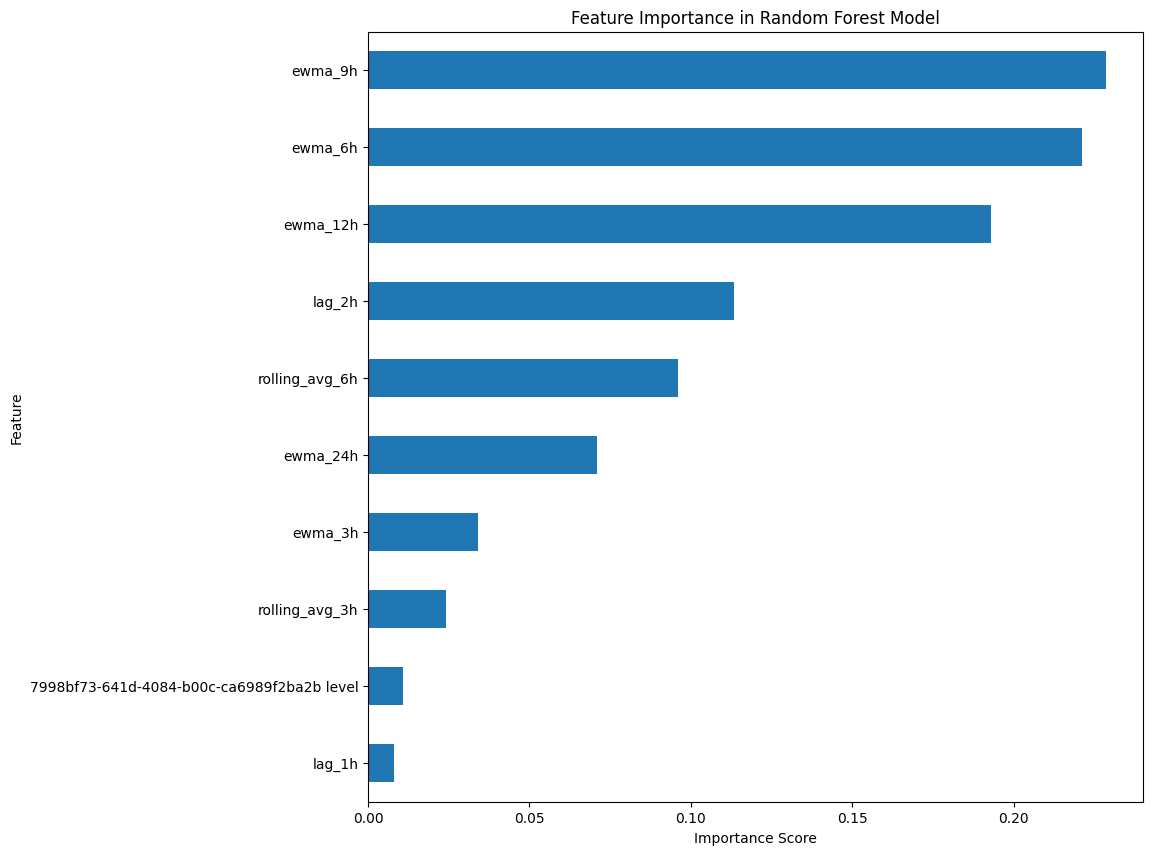

In [0]:
# Get feature importance from the best model found by GridSearchCV.
feature_importances = pd.Series(best_model.feature_importances_, index=features)

#Sort and plot.
feature_importances.sort_values().plot(kind="barh", figsize=(10, 10))
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.show()

#The model relies heavily on EWMA and rolling averages, emphasising longer-term trends over sudden changes.This suggests that predicting flood warnings requires monitoring how water levels evolve over time, rather than just looking at individual readings and that there is not automation to the flood warnings. 

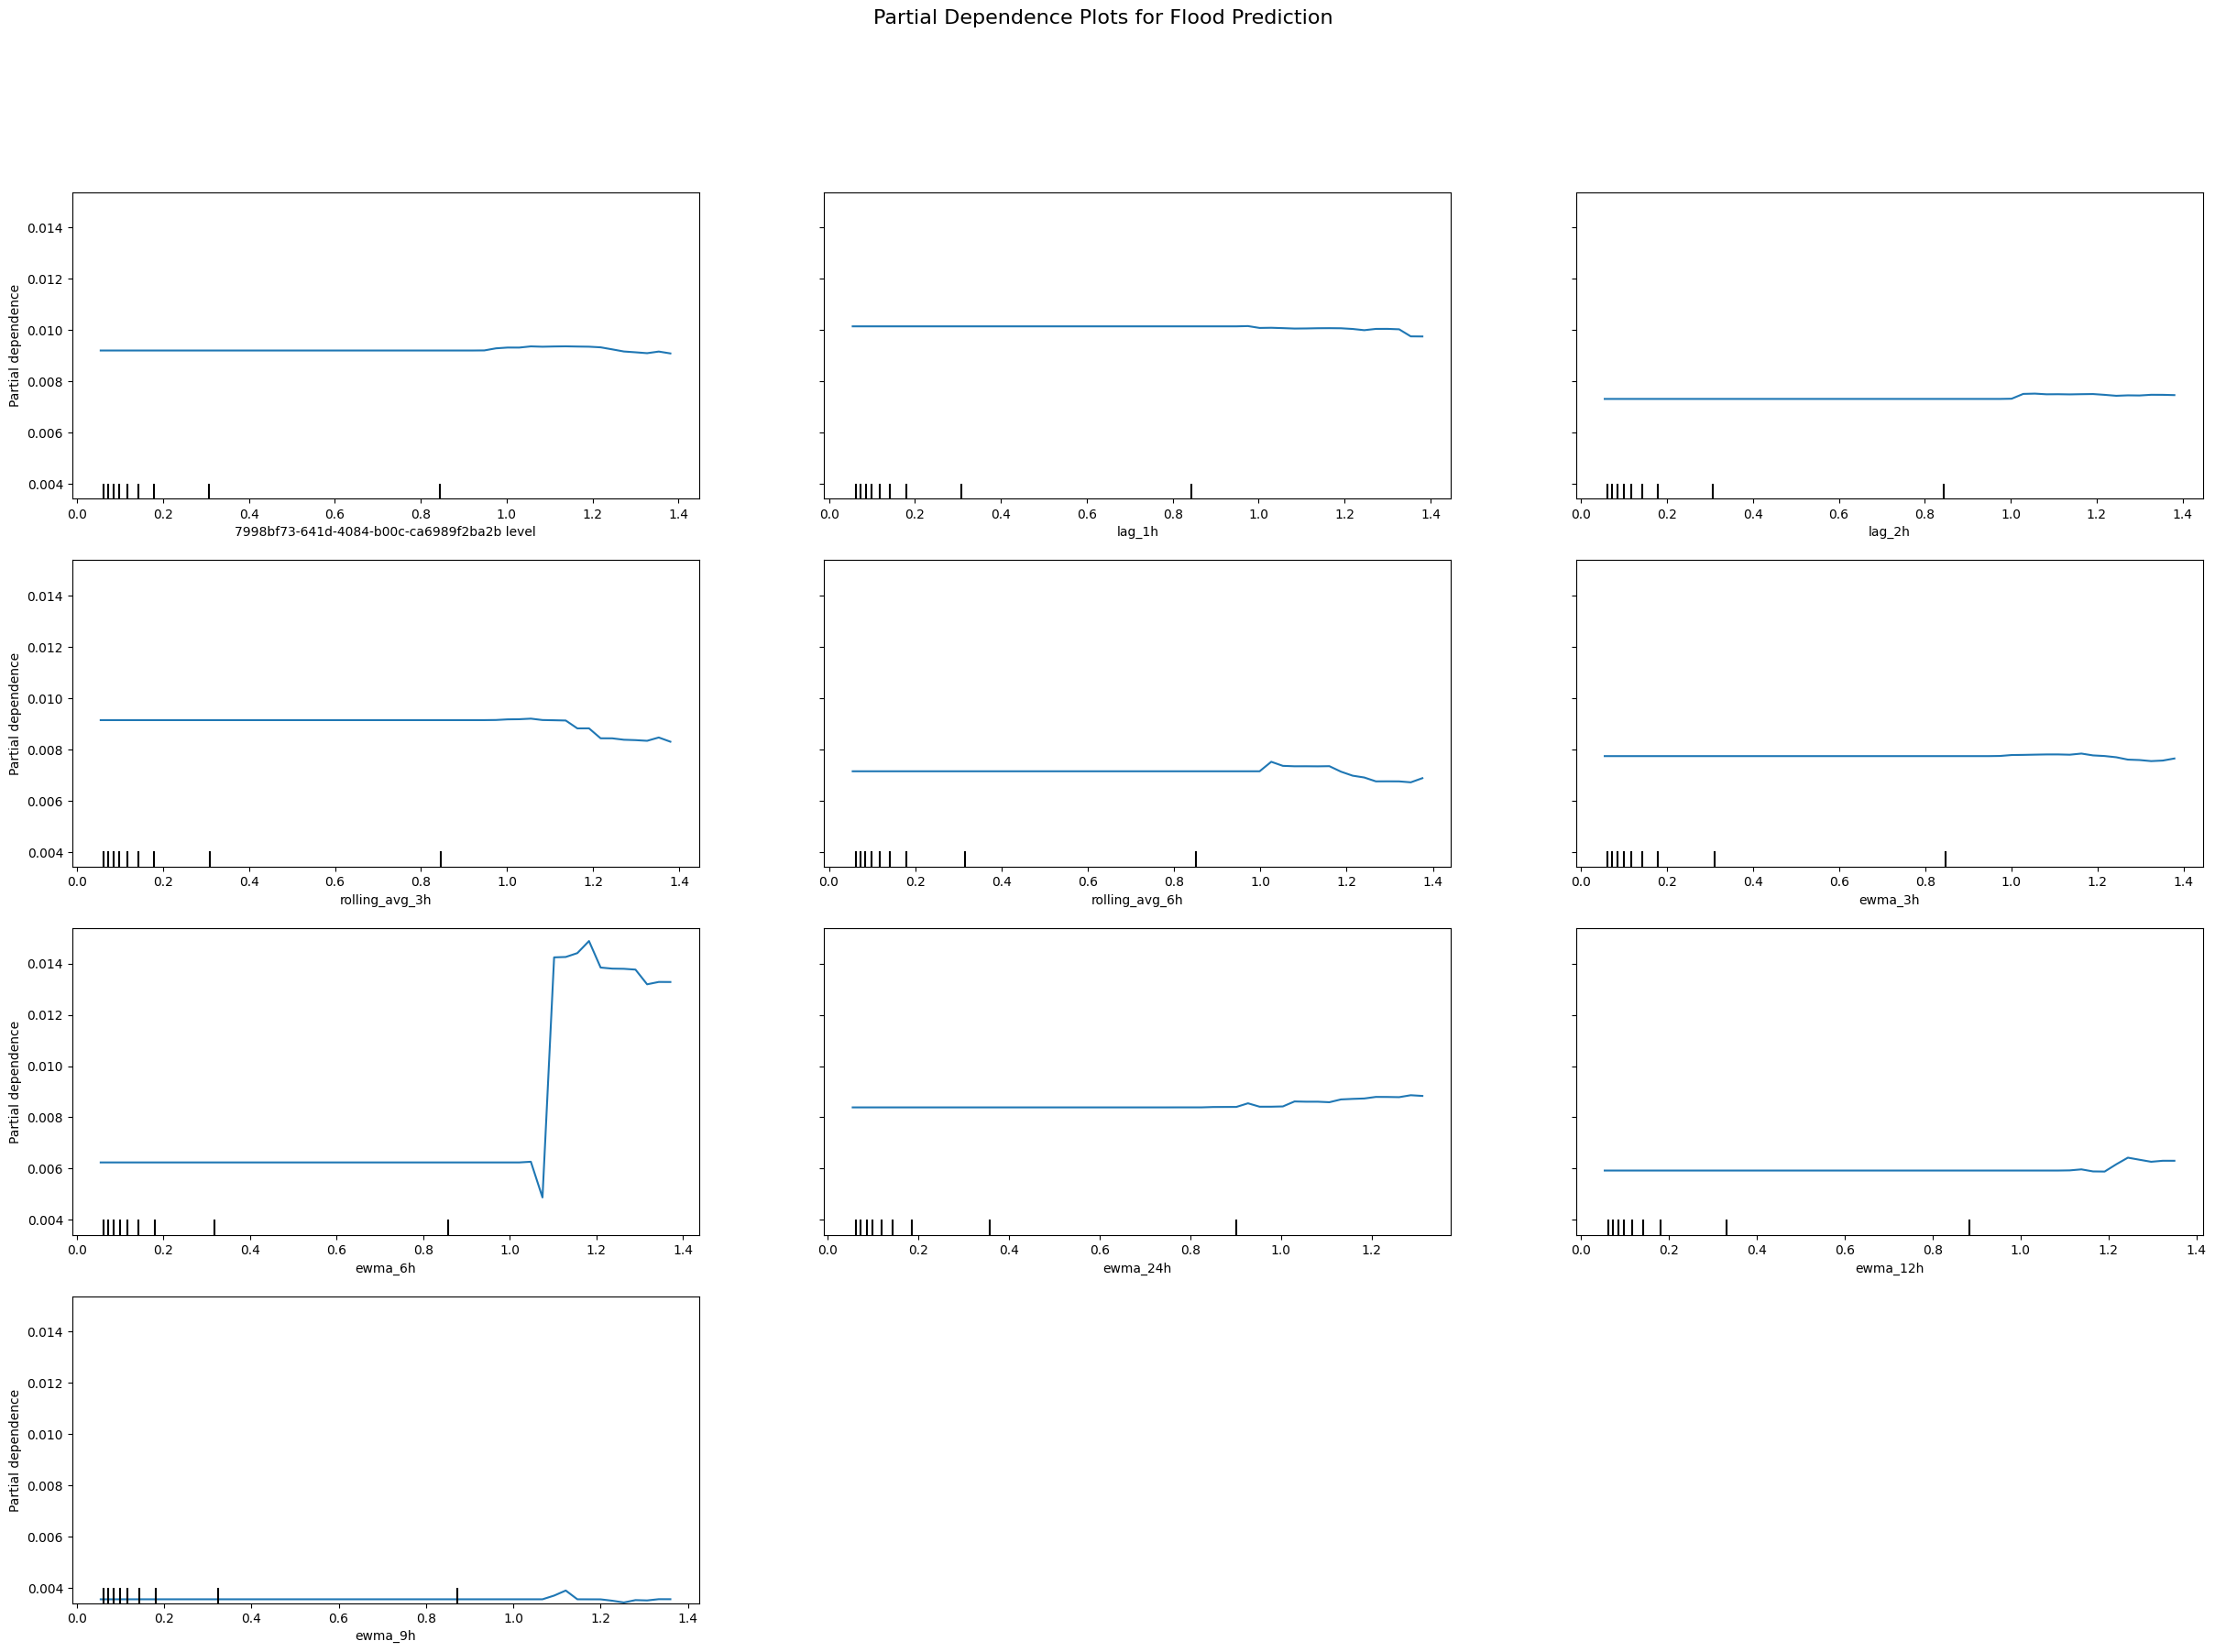

In [0]:
#Create a PDP plot for each feature from the best model found by GridSearchCV.
features_to_plot = X_train.columns.tolist()

#Create a larger figure.
fig, ax = plt.subplots(figsize=(30, 20)) 

#Generate Partial Dependence Plots using the best model.
PartialDependenceDisplay.from_estimator(
    best_model,
    X_train,
    features=features_to_plot,
    target=1,
    grid_resolution=50,
    ax=ax
)
plt.suptitle("Partial Dependence Plots for Flood Prediction", fontsize=16)
plt.show()

#The ewma_6h exhibits a sharp increase at around 1.2–1.3, suggesting a threshold effect where flood probability significantly rises past this level.Features like rolling_avg_6h and ewma_24h display a slight upward slope, indicating a weak positive correlation with flood probability.

## 2) Adding Rainfall Features

In [0]:
# Load Rainfall data.
rainfall = pd.read_csv(os.path.join("Data", "Average_Hourly_Rainfall.csv")) 
rainfall

,dateTime,rainfall_cumulative_12h,rainfall_cumulative_3d,rainfall_cumulative_2w,rainfall_2w_lagged
0,2019-01-01 00:00:00,0.0,0.00000,0.00000,NaN
1,2019-01-01 01:00:00,0.0,0.00000,0.00000,NaN
2,2019-01-01 02:00:00,0.0,0.00000,0.00000,NaN
3,2019-01-01 03:00:00,0.0,0.00000,0.00000,NaN
4,2019-01-01 04:00:00,0.0,0.00000,0.00000,NaN
...,...,...,...,...,...
54292,2025-03-12 04:00:00,0.0,0.07525,3.05400,0.00000
54293,2025-03-12 05:00:00,0.0,0.07525,2.99425,0.05975
54294,2025-03-12 06:00:00,0.0,0.07525,1.98200,1.01225
54295,2025-03-12 07:00:00,0.0,0.07525,0.63575,1.34625


In [0]:
level_warnings

,Approved,daily_indicator,dateTime,7998bf73-641d-4084-b00c-ca6989f2ba2b level,ce5176cf-1523-4dbe-855f-17a0efffbe02 level,lag_1h,lag_2h,rolling_avg_3h,rolling_avg_6h,ewma_3h,ewma_6h,ewma_24h,ewma_12h,ewma_9h
5,2019-12-19 06:00:00,1,2019-12-19 06:00:00,2.190,2.293,2.204,2.229,2.207667,2.245500,2.209500,2.232896,2.270876,2.255134,2.246548
6,2019-12-19 07:00:00,1,2019-12-19 07:00:00,2.177,2.294,2.190,2.204,2.190333,2.226500,2.193250,2.216925,2.263366,2.243114,2.232638
7,2019-12-19 08:00:00,1,2019-12-19 08:00:00,2.157,2.291,2.177,2.190,2.174667,2.203833,2.175125,2.199804,2.254857,2.229865,2.217511
8,2019-12-19 09:00:00,1,2019-12-19 09:00:00,2.133,2.553,2.157,2.177,2.155667,2.181667,2.154063,2.180717,2.245108,2.214963,2.200608
9,2019-12-19 10:00:00,1,2019-12-19 10:00:00,2.109,4.276,2.133,2.157,2.133000,2.161667,2.131531,2.160226,2.234219,2.198661,2.182287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43266,2024-11-24 19:00:00,1,2024-11-24 19:00:00,2.334,2.520,2.263,2.203,2.266667,2.205667,2.277196,2.239313,2.067280,2.213062,2.226472
43267,2024-11-24 20:00:00,1,2024-11-24 20:00:00,2.379,2.513,2.334,2.263,2.325333,2.247000,2.328098,2.279223,2.092218,2.238591,2.256978
43268,2024-11-24 21:00:00,1,2024-11-24 21:00:00,2.404,2.503,2.379,2.334,2.372333,2.291167,2.366049,2.314874,2.117160,2.264038,2.286382
43269,2024-11-24 22:00:00,1,2024-11-24 22:00:00,2.410,2.506,2.404,2.379,2.397667,2.332167,2.388025,2.342053,2.140587,2.286494,2.311106


In [0]:
# Ensure 'dateTime' is in datetime format
level_warnings['dateTime'] = pd.to_datetime(level_warnings['dateTime'])
rainfall['dateTime'] = pd.to_datetime(rainfall['dateTime'])

# Merge on 'dateTime'
merged_df = level_warnings.merge(rainfall, on='dateTime', how='inner')

In [0]:
merged_df

,Approved,daily_indicator,dateTime,7998bf73-641d-4084-b00c-ca6989f2ba2b level,ce5176cf-1523-4dbe-855f-17a0efffbe02 level,lag_1h,lag_2h,rolling_avg_3h,rolling_avg_6h,ewma_3h,ewma_6h,ewma_24h,ewma_12h,ewma_9h,rainfall_cumulative_12h,rainfall_cumulative_3d,rainfall_cumulative_2w,rainfall_2w_lagged
0,2019-12-19 06:00:00,1,2019-12-19 06:00:00,2.190,2.293,2.204,2.229,2.207667,2.245500,2.209500,2.232896,2.270876,2.255134,2.246548,0.65000,4.70000,15.90000,0.0
1,2019-12-19 07:00:00,1,2019-12-19 07:00:00,2.177,2.294,2.190,2.204,2.190333,2.226500,2.193250,2.216925,2.263366,2.243114,2.232638,0.45000,4.70000,15.90000,0.0
2,2019-12-19 08:00:00,1,2019-12-19 08:00:00,2.157,2.291,2.177,2.190,2.174667,2.203833,2.175125,2.199804,2.254857,2.229865,2.217511,0.40000,4.70000,15.90000,0.0
3,2019-12-19 09:00:00,1,2019-12-19 09:00:00,2.133,2.553,2.157,2.177,2.155667,2.181667,2.154063,2.180717,2.245108,2.214963,2.200608,0.40000,4.70000,15.90000,0.0
4,2019-12-19 10:00:00,1,2019-12-19 10:00:00,2.109,4.276,2.133,2.157,2.133000,2.161667,2.131531,2.160226,2.234219,2.198661,2.182287,0.40000,4.70000,15.90000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43261,2024-11-24 19:00:00,1,2024-11-24 19:00:00,2.334,2.520,2.263,2.203,2.266667,2.205667,2.277196,2.239313,2.067280,2.213062,2.226472,5.17225,11.87375,19.55875,0.0
43262,2024-11-24 20:00:00,1,2024-11-24 20:00:00,2.379,2.513,2.334,2.263,2.325333,2.247000,2.328098,2.279223,2.092218,2.238591,2.256978,5.04125,11.90150,19.58650,0.0
43263,2024-11-24 21:00:00,1,2024-11-24 21:00:00,2.404,2.503,2.379,2.334,2.372333,2.291167,2.366049,2.314874,2.117160,2.264038,2.286382,4.22400,11.90475,19.58975,0.0
43264,2024-11-24 22:00:00,1,2024-11-24 22:00:00,2.410,2.506,2.404,2.379,2.397667,2.332167,2.388025,2.342053,2.140587,2.286494,2.311106,3.03825,11.90475,19.58975,0.0


In [0]:
excluded_cols = ["Approved", "dateTime", "daily_indicator", 'ce5176cf-1523-4dbe-855f-17a0efffbe02 level']
features = [col for col in merged_df.columns if col not in excluded_cols]

features

['7998bf73-641d-4084-b00c-ca6989f2ba2b level',
 'lag_1h',
 'lag_2h',
 'rolling_avg_3h',
 'rolling_avg_6h',
 'ewma_3h',
 'ewma_6h',
 'ewma_24h',
 'ewma_12h',
 'ewma_9h',
 'rainfall_cumulative_12h',
 'rainfall_cumulative_3d',
 'rainfall_cumulative_2w',
 'rainfall_2w_lagged']

In [0]:
#Chronological train/test split:
train = merged_df[merged_df["dateTime"] < "2024-01-01"]
test = merged_df[merged_df["dateTime"] >= "2024-01-01"]

#Separate into X (features) and y (target).
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

#Print dataset sizes.
print("Train size:", len(X_train), "rows")
print("Test size:", len(X_test), "rows")

#Count occurrences of daily_indicator == 1 (flood events).
train_flood_count = y_train.value_counts().get(1, 0)
test_flood_count = y_test.value_counts().get(1, 0)

#Print flood counts.
print(f"Flood events in train set (daily_indicator=1): {train_flood_count}")
print(f"Flood events in test set (daily_indicator=1): {test_flood_count}")

Train size: 35370 rows
Test size: 7896 rows
Flood events in train set (daily_indicator=1): 382
Flood events in test set (daily_indicator=1): 67


In [0]:
#Define the parameter grid tailored for imbalanced data.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    # Using class_weight to counter the imbalance:
    'class_weight': ["balanced", "balanced_subsample"]  
}

#Initialise the Random Forest classifier without fixed parameters so grid search can explore.
rf = RandomForestClassifier(random_state=42)

#Using StratifiedKFold to preserve the imbalance ratio in each fold.
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Set up GridSearchCV using StratifiedKFold split and 'F1' as the scoring metric.
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=cv_strategy,
                           scoring='f1',  
                           n_jobs=-1,
                           verbose=1)

#Fit the grid search on the training data.
grid_search.fit(X_train, y_train)

#Output the best parameters and best score.
print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

#Retrieve the best model from grid search.
best_model = grid_search.best_estimator_

#Make predictions on the test set.
y_pred = best_model.predict(X_test)

#Evaluate the model's performance.
print(classification_report(y_test, y_pred))

#The inclusion of rainfall features has resulted in a more balanced Random Forest model with 0.79 precision and 0.73 recall. 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run serious-bug-604 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/a712bd36d5204b31b89d2ce0cb514b4a
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run likeable-doe-77 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/9528fab1a4a245428ec6b57205141ebc
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run mysterious-pug-722 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/8ae2098abb734c97990d3d3c5967f162
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run polite-bass-672 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/69b900cbdc4045c1a498a40b39933450
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/m

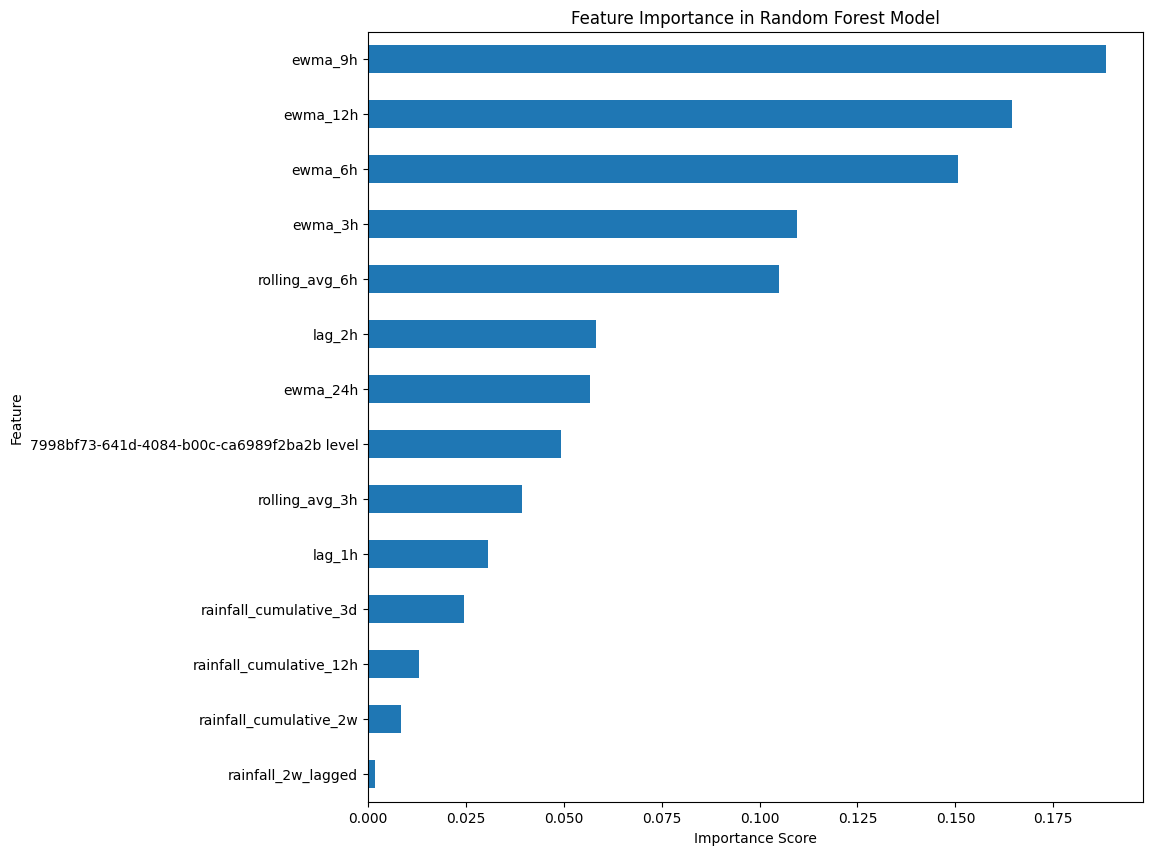

In [0]:
# Get feature importance from the best model found by GridSearchCV.
feature_importances = pd.Series(best_model.feature_importances_, index=features)

#Sort and plot.
feature_importances.sort_values().plot(kind="barh", figsize=(10, 10))
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.show()

#Flood prediction is still primarily driven by river level trends, with short-term and mid-term EWMAs leading the importance ranking. I think more work is needed to make the rainfall data relevant to the performance of the model - as seen in the PREPROCESSING EDA for rainfall, the correlation between rainfall (even lagged and rolling) is weak for some reason which should be investigated. 

## 3) Adding Flow Features

In [0]:
# Load the Flow data. 
flow = pd.read_csv(os.path.join("Data", "Flow_Cleaned_Hourly.csv")) 
flow

,station,dateTime,flow
0,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 00:00:00,21.454
1,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 01:00:00,29.052
2,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 02:00:00,29.238
3,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 03:00:00,26.812
4,7998bf73-641d-4084-b00c-ca6989f2ba2b,2019-12-19 04:00:00,23.769
...,...,...,...
43267,7998bf73-641d-4084-b00c-ca6989f2ba2b,2024-11-24 19:00:00,33.286
43268,7998bf73-641d-4084-b00c-ca6989f2ba2b,2024-11-24 20:00:00,38.277
43269,7998bf73-641d-4084-b00c-ca6989f2ba2b,2024-11-24 21:00:00,41.319
43270,7998bf73-641d-4084-b00c-ca6989f2ba2b,2024-11-24 22:00:00,42.080


In [0]:
flow.rename(columns={"value": "flow"}, inplace=True)

In [0]:
flow.drop(columns=['station'], inplace=True)
flow

,dateTime,flow
0,2019-12-19 00:00:00,21.454
1,2019-12-19 01:00:00,29.052
2,2019-12-19 02:00:00,29.238
3,2019-12-19 03:00:00,26.812
4,2019-12-19 04:00:00,23.769
...,...,...
43267,2024-11-24 19:00:00,33.286
43268,2024-11-24 20:00:00,38.277
43269,2024-11-24 21:00:00,41.319
43270,2024-11-24 22:00:00,42.080


In [0]:
flow.isna().sum()

dateTime    0
flow        0
dtype: int64

In [0]:
# Ensure 'dateTime' is in datetime format
merged_df['dateTime'] = pd.to_datetime(merged_df['dateTime'])
flow['dateTime'] = pd.to_datetime(flow['dateTime'])

# Merge on 'dateTime'
merged_df = merged_df.merge(flow, on='dateTime', how='inner')

In [0]:
#Create lagged features for the level column using 1, 2, and 6 hour lags.
merged_df['flow lag_1h'] = merged_df['flow'].shift(1)
merged_df['flow lag_2h'] = merged_df['flow'].shift(2)


#Define rolling window sizes in hours (up to 48 hours).
rolling_windows_hours = [3, 6]

#Create rolling average features for each window size.
for window in rolling_windows_hours:
    col_name = f'flow_rolling_avg_{window}h'
    merged_df[col_name] = merged_df['flow'].rolling(window=window).mean()

#Apply Exponential Weighted Moving Average (EWMA) with various spans (in hours).
ewma_spans = [3, 6, 24, 12, 9]
for span in ewma_spans:
    col_name = f'flow_ewma_{span}h'
    merged_df[col_name] = merged_df['flow'].ewm(span=span, adjust=False).mean()

merged_df

             Approved  daily_indicator  ... flow_ewma_12h  flow_ewma_9h
0 2019-12-19 06:00:00                1  ...     20.890000     20.890000
1 2019-12-19 07:00:00                1  ...     20.752923     20.711800
2 2019-12-19 08:00:00                1  ...     20.436166     20.308240
3 2019-12-19 09:00:00                1  ...     19.941986     19.691392
4 2019-12-19 10:00:00                1  ...     19.313373     18.924314
5 2019-12-19 11:00:00                1  ...     18.569777     18.035451
6 2019-12-19 12:00:00                1  ...     17.788735     17.126961
7 2019-12-19 13:00:00                1  ...     17.012929     16.250769
8 2019-12-19 14:00:00                1  ...     16.493709     15.728215
9 2019-12-19 15:00:00                0  ...     16.263446     15.581972

[10 rows x 28 columns]


In [0]:
#Dropping nulls from the feature engineering process. 
merged_df.dropna(inplace=True)

In [0]:
#Redefining features. 
excluded_cols = ["Approved", "dateTime", "daily_indicator", 'ce5176cf-1523-4dbe-855f-17a0efffbe02 level', '7998bf73-641d-4084-b00c-ca6989f2ba2b level', 'flow' ]
features = [col for col in merged_df.columns if col not in excluded_cols]
features

['lag_1h',
 'lag_2h',
 'rolling_avg_3h',
 'rolling_avg_6h',
 'ewma_3h',
 'ewma_6h',
 'ewma_24h',
 'ewma_12h',
 'ewma_9h',
 'rainfall_cumulative_12h',
 'rainfall_cumulative_3d',
 'rainfall_cumulative_2w',
 'rainfall_2w_lagged',
 'flow lag_1h',
 'flow lag_2h',
 'flow_rolling_avg_3h',
 'flow_rolling_avg_6h',
 'flow_ewma_3h',
 'flow_ewma_6h',
 'flow_ewma_24h',
 'flow_ewma_12h',
 'flow_ewma_9h']

In [0]:
#Chronological train/test split:
train = merged_df[merged_df["dateTime"] < "2024-01-01"]
test = merged_df[merged_df["dateTime"] >= "2024-01-01"]

#Separate into X (features) and y (target).
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

#Print dataset sizes.
print("Train size:", len(X_train), "rows")
print("Test size:", len(X_test), "rows")

#Count occurrences of daily_indicator == 1 (flood events).
train_flood_count = y_train.value_counts().get(1, 0)
test_flood_count = y_test.value_counts().get(1, 0)

#Print flood counts.
print(f"Flood events in train set (daily_indicator=1): {train_flood_count}")
print(f"Flood events in test set (daily_indicator=1): {test_flood_count}")

Train size: 35365 rows
Test size: 7896 rows
Flood events in train set (daily_indicator=1): 377
Flood events in test set (daily_indicator=1): 67


In [0]:

#Define the parameter grid tailored for imbalanced data.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    # Using class_weight to counter the imbalance:
    'class_weight': ["balanced", "balanced_subsample"]  
}

#Initialise the Random Forest classifier without fixed parameters so grid search can explore.
rf = RandomForestClassifier(random_state=42)

#Using StratifiedKFold to preserve the imbalance ratio in each fold.
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Set up GridSearchCV with StratifiedKFold as the cross-validation strategy and F1 score as the evaluation metric.
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=cv_strategy,
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=1)

#Fit the grid search on the training data.
grid_search.fit(X_train, y_train)

# Output the best parameters and best score.
print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

#Retrieve the best model from grid search.
best_model = grid_search.best_estimator_

#Make predictions on the test set.
y_pred = best_model.predict(X_test)

#Evaluate the model's performance.
print(classification_report(y_test, y_pred))

#The flow-based model offers a strong balance between detecting floods (recall) and avoiding false alarms (precision) and outperforms all previous models. I could adjust the decision threshold (e.g., reducing from 0.5 to 0.4) to help catch additional cases, but I will leave it at this point for now. 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bouncy-trout-430 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/3c65169b294448af95f5324c7baed305
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run hilarious-bug-863 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/c5a025900a8e43dbbea858bcb767cd7b
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run grandiose-grub-424 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/f65aaba2cf234015aa143254ba7247b5
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
🏃 View run clean-slug-475 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/3fda25aa8d1c40fc90d24237052e0421
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net

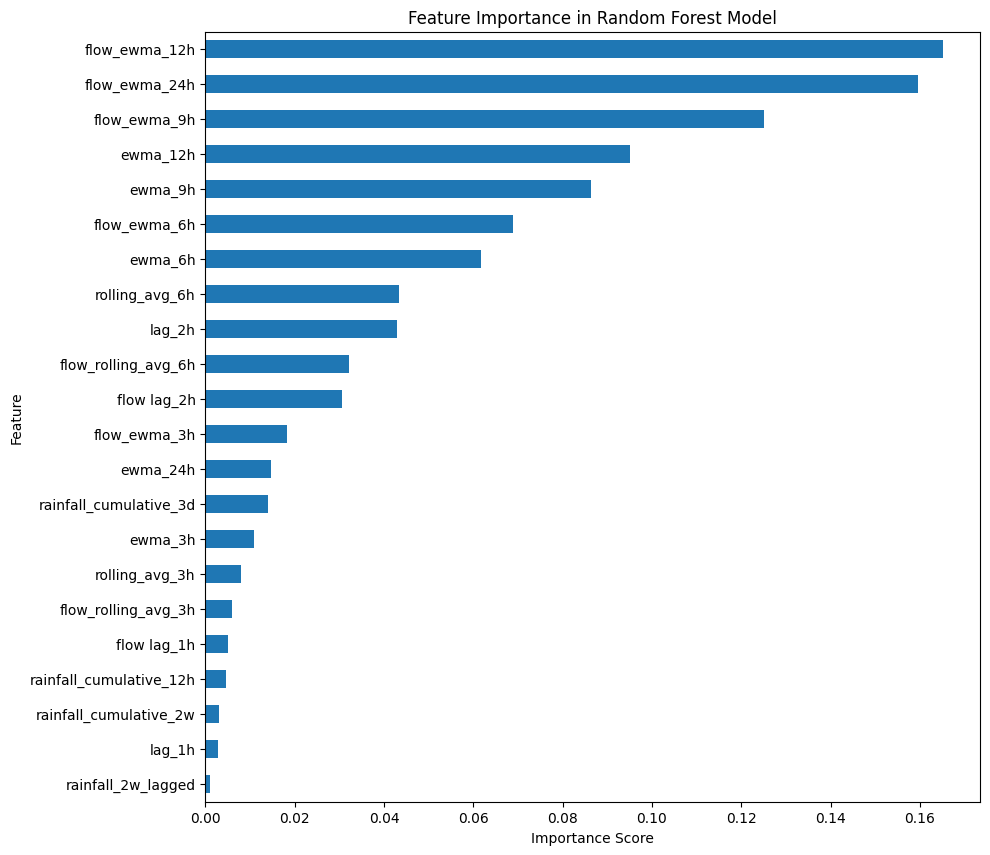

In [0]:
#Get feature importance from the best model found by GridSearchCV.
feature_importances = pd.Series(best_model.feature_importances_, index=features)

#Sort and plot.
feature_importances.sort_values().plot(kind="barh", figsize=(10, 10))
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.show()

#Flow-based moving averages are now the strongest predictors, suggesting that floods are better signaled by long-term flow changes rather than just rainfall or water levels.Water level EWMAs remain important, but they take a secondary role compared to flow trends.

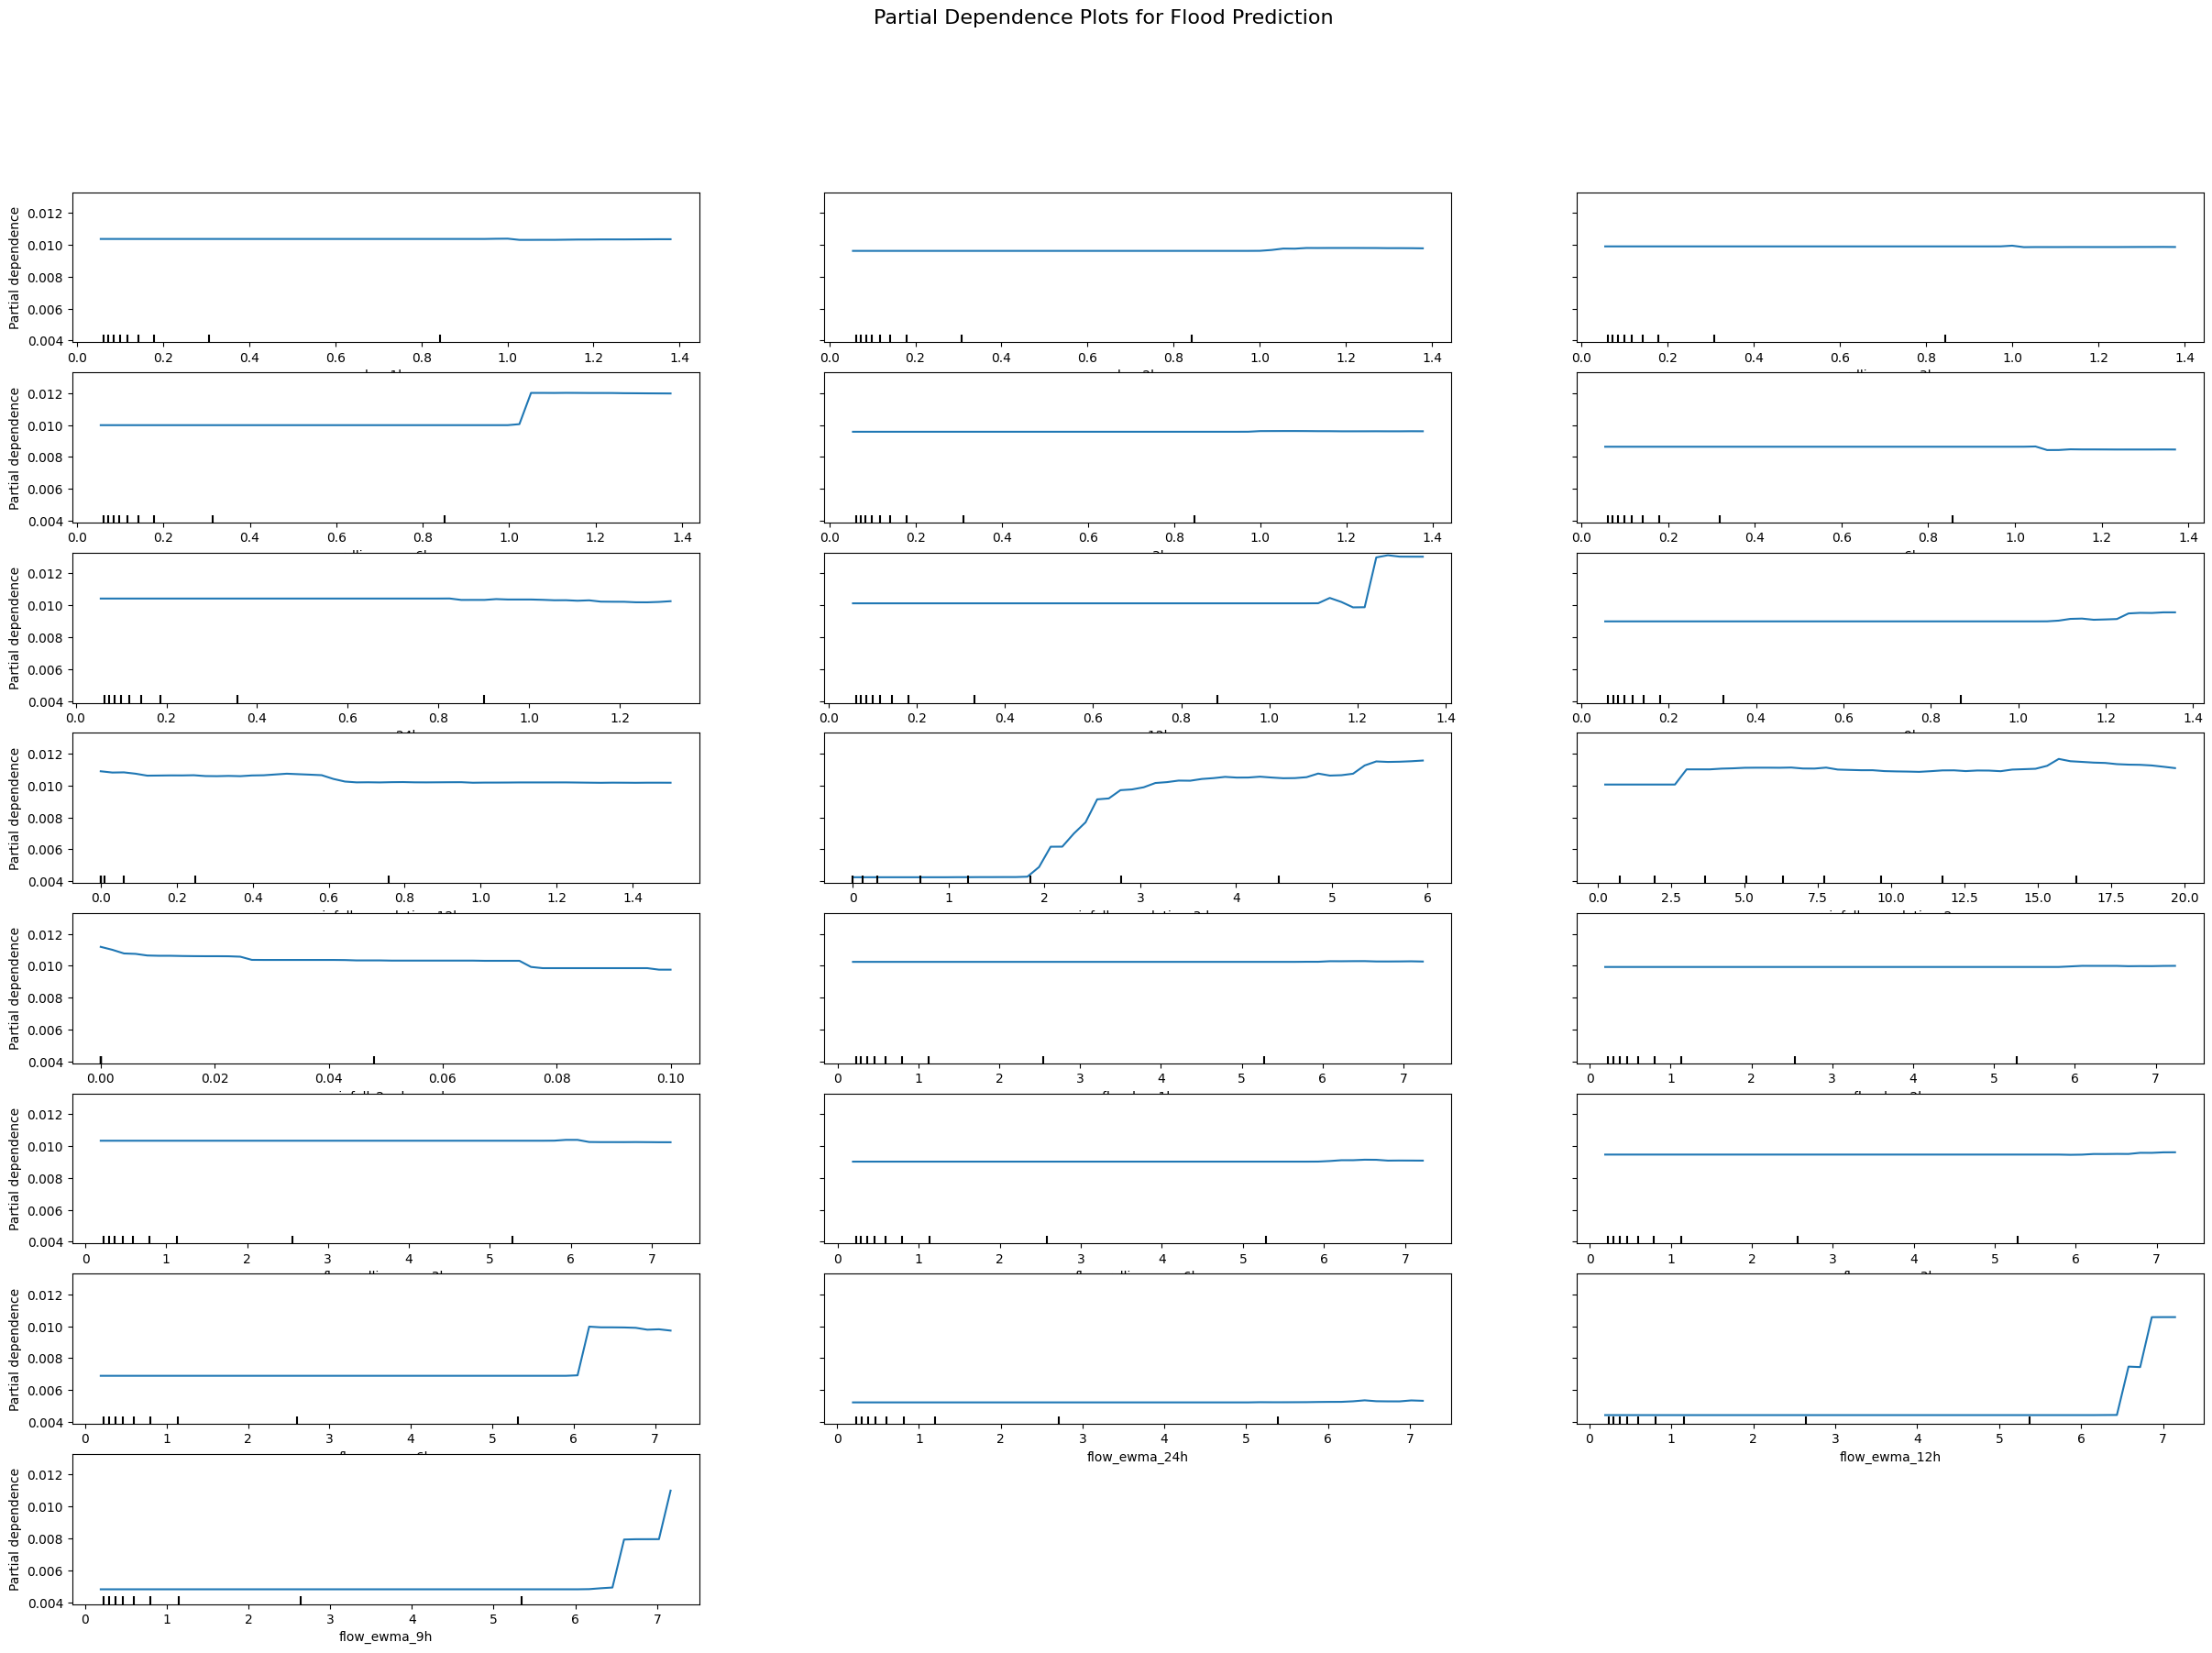

In [0]:
#Create a PDP plot for each feature from the best model found by GridSearchCV.
features_to_plot = X_train.columns.tolist()

#Create a larger figure.
fig, ax = plt.subplots(figsize=(30, 20)) 

#Generate Partial Dependence Plots using the best model.
PartialDependenceDisplay.from_estimator(
    best_model,
    X_train,
    features=features_to_plot,
    target=1,
    grid_resolution=50,
    ax=ax
)
plt.suptitle("Partial Dependence Plots for Flood Prediction", fontsize=16)
plt.show()

#This confirms that flow trends, particularly 5-12 hour EWMAs, are crucial for predicting floods, while cumulative rainfall provides additional but gradual predictive power. In the future, I could use this output to optimise the model through feature selection and alternative aggregation based on what seems to work the best for predictions. 

In [0]:
#Train a simple Decision Tree on the top features to get the values for flood warnings. 
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_model.fit(X_train, y_train)

#Extract the threhold values. 
tree_rules = export_text(dt_model, feature_names=list(X_train.columns))
print(tree_rules)

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run receptive-mule-507 at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953/runs/c2febb5ab22b4d839f4269915fcbca7a
🧪 View experiment at: https://adb-7393756451346106.6.azuredatabricks.net/ml/experiments/1932511080884953
|--- flow_ewma_12h <= 16.04
|   |--- flow_ewma_12h <= 11.55
|   |   |--- flow_ewma_24h <= 10.65
|   |   |   |--- flow_ewma_3h <= 17.86
|   |   |   |   |--- class: 0
|   |   |   |--- flow_ewma_3h >  17.86
|   |   |   |   |--- class: 1
|   |   |--- flow_ewma_24h >  10.65
|   |   |   |--- rainfall_cumulative_3d <= 12.69
|   |   |   |   |--- class: 0
|   |   |   |--- rainfall_cumulative_3d >  12.69
|   |   |   |   |--- class: 1
|   |--- flow_ewma_12h >  11.55
|   |   |--- rainfall_cumulative_3d <= 5.95
|   |   |   |--- rainfall_cumulative_2w <= 8.07
|   |   |   |   |--- class: 1
|   |   |   |--- rainfall_cumulative_2w >  8.07
|   |   |   |   |--- class: 0
|   |   |--- rainfall_cumulative_3d >  5.95
|   |   |   |--- rainfall_cumulative

From the deicsion tree, the thresholds for a flood warning are:

flow_ewma_12h	> 16.04
flow_ewma_3h	> 17.86 (if others are moderate)
rainfall_cumulative_3d	> 12.69 mm
ewma_6h / ewma_12h	> 2.08 / 2.13

# Results 
Using only Environment Agency hydrology ensor data, the final Random Forest classification model achieved a much better balance between flood detection and false alarms compared to the initial baseline. Early on, a simple Logistic Regression yielded high overall accuracy but failed to catch many flood events due to extreme class imbalance. Replacing this with a Random Forest improved flood recall dramatically (catching around 90% of flood events in the baseline RF model) but initially at the cost of many false positives. Through class rebalancing and hyperparameter tuning, the model reached a more reasonable trade-off – after tuning, the Random Forest was able to identify about 84% of flood days while reducing false alarms (precision around 57% for flood class, up from 31% baseline). Incorporating additional features further boosted performance: adding cumulative rainfall data produced a model with roughly 0.73 recall and 0.79 precision for flood warnings (a notably more balanced outcome), and  including river flow features pushed performance to its best levels. The final model (with levels, rainfall, and flow inputs) detects most flood warning hours while keeping the false-alarm rate relatively low, outperforming all previous versions with 0.88 precision and 0.76 recall and 0.82 F1.

# Next Steps 
Given that some flood events are still missed, one immediate refinement is adjusting the classifier’s probability threshold. The current model uses the default 0.5 threshold to decide a “flood” warning. Lowering this threshold (e.g. to 0.4) could catch a few more flood events at the expense of more false positives. While the Random Forest has performed well, exploring other machine learning algorithms could yield further improvements. A natural next step is to try Gradient Boosting Machines such as XGBoost or LightGBM. Another avenue is to consider time-series specific models. Since flood warnings are inherently time-sequenced events, models like recurrent neural networks (LSTM/GRU) or sequence classification approaches could capture temporal patterns beyond the fixed lag features we engineered.